# __Implementation__

In [4]:
!pip install pandas_read_xml

In [5]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk import jaccard_distance
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score

plt.style.use('seaborn-whitegrid') # plot style

### Jupyter load

In [6]:
import os
fpcora = os.path.abspath("./data/cora1stEdition/CORA.xml")
fpcora_gold = os.path.abspath("./data/cora1stEdition/cora_gold.csv")

In [7]:
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
xml_dataframe = cora
xml_dataframe['@id'] = pd.to_numeric(xml_dataframe['@id']).subtract(1)
xml_dataframe.head(30)

,@id,author,title,journal,volume,pages,date,#text,publisher,address,note,booktitle,editor,booktile,tech,institution,Pages,year,type,month
0,0,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",Inganas and M.R.,"Andersson, J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"J Appl. Phys.,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,"M. Ahlskog, J. Paloheimo, H. Stubb, P. Dyrekle...",NaN,"Journal of Applied Physics,","76,","893,",(1994).,ahlskog1994a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,C. Ray Asfahl.,Robots and Manufacturing Automation.,NaN,NaN,NaN,1992.,asfahl1992a,"John Wiley and Sons,","New York,","second edition,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,Steve Benford and Lennart E. Fahlen.,A spatial model of interaction in large virtua...,NaN,NaN,NaN,"[September, 1993.]",benford1993a,NaN,"Milan,",NaN,"In Proceedings of ECSCW'93,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Import true values


In [8]:
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)
cora_glod_30 = cora_gold.head(47)
cora_glod_30

,id1,id2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,0,6
6,0,7
7,1,2
8,1,3
9,1,4


### Preprocess

In [9]:
def preprocess(row):

    paper_str = " ".join(row)
    paper_str = paper_str.lower()
    paper_str = paper_str.replace("\n", " ").replace("/z", " ").replace("[","").replace("]","").replace(",", " ")

    return str(paper_str)

### Shuffle data

In [11]:
shuffled_df = xml_dataframe.head(30).sample(frac=1).reset_index(drop=True)
# shuffled_df

### Creating dataset with 30 records

In [10]:
def cora_createDataset(xml_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(xml_dataframe.iterrows()):
        index_to_id_dict[int(row['@id'])] = i

        rawStr = []
        for field in fields:    # NAN
            if not (keepNone == False and field == None):
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(xml_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
#             print('here')
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

    print(cluster_dict)
    print(clusters)
    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters


# fields = ['author', 'title', 'journal', 'volume', 'pages', 'date', '#text',
#        'publisher', 'address', 'note', 'booktitle', 'editor', 'booktile',
#        'tech', 'institution', 'Pages', 'year', 'type', 'month']

fields = ['author', 'title', 'journal']

data, true_labels, true_matrix, clusters = cora_createDataset(xml_dataframe.head(30), cora_glod_30, fields)

cora_glod_30['cluster_id'] = clusters

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{0: {0, 1, 2, 3, 4, 5, 6, 7}, 1: {11, 12, 13}, 2: {16, 17, 15}, 3: {18, 19, 20, 21, 22}, 4: {26, 27, 28}}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4]


C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# print(true_matrix)

In [11]:
# groups = cora_glod_30.groupby(cora_glod_30.cluster_id)
# groups.groups
groups = cora_glod_30.groupby('cluster_id').agg(list)
groups['cluster_items'] = groups['id1']+groups['id2']
groups['cluster_items'][0]

clusters = []
for _,r in groups.iterrows():
    l = list(set(x for x in r['cluster_items']))
    print(l)
#     l = l.sort()
    clusters.append(sorted(l))
clusters

[0, 1, 2, 3, 4, 5, 6, 7]
[11, 12, 13]
[16, 17, 15]
[18, 19, 20, 21, 22]
[26, 27, 28]


[[0, 1, 2, 3, 4, 5, 6, 7],
 [11, 12, 13],
 [15, 16, 17],
 [18, 19, 20, 21, 22],
 [26, 27, 28]]

## Dataset inspection

#### String length

In [12]:
data_length = [ len(x) for x in data ]
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))
print("Median length: %d" % (np.median(data_length)))

Average length: 112
Min length: 55
Max length: 209
Median length: 110


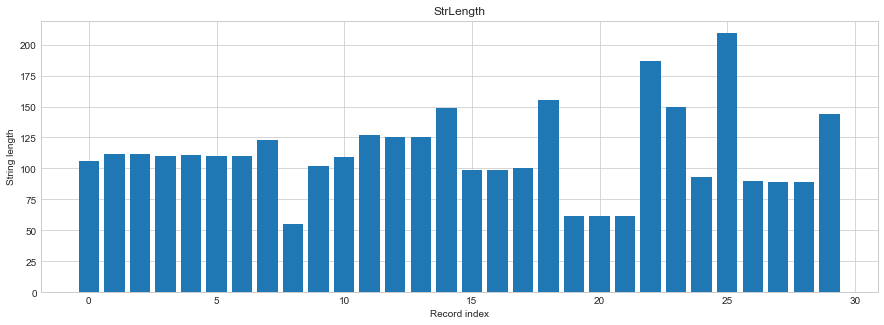

In [13]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

## Jaccard VS Edit distance variance

In [18]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [39]:
import math
ed_matrix  = np.zeros((len(data),len(data)))
jc2_matrix = np.zeros((len(data),len(data)))
jc3_matrix = np.zeros((len(data),len(data)))
js2_matrix = np.zeros((len(data),len(data)))
js3_matrix = np.zeros((len(data),len(data)))


ejs2_matrix = np.zeros((len(data),len(data)))
ejs3_matrix = np.zeros((len(data),len(data)))

ejc3_matrix = np.zeros((len(data),len(data)))
ejc2_matrix = np.zeros((len(data),len(data)))

for i in range(0,len(data),1):
    for j in range(0,len(data),1):
        if i != j:
            ed_matrix[i][j]  = editdistance.eval(data[i],data[j])
            jc3_matrix[i][j] = (1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=3)),set(nltk.ngrams(data[j], n=3))))
            js3_matrix[i][j] = (1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=3)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=3))))
            jc2_matrix[i][j] = (1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=2)),set(nltk.ngrams(data[j], n=2))))
            js2_matrix[i][j] = (1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=2)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=2))))
            ejc2_matrix[i][j] = math.sqrt(1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=2)),set(nltk.ngrams(data[j], n=2))))
            ejs2_matrix[i][j] = math.sqrt(1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=2)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=2))))
            ejc3_matrix[i][j] = math.sqrt(1-nltk.jaccard_distance(set(nltk.ngrams(data[i], n=3)),set(nltk.ngrams(data[j], n=3))))
            ejs3_matrix[i][j] = math.sqrt(1-nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(data[i]), n=3)),set(nltk.ngrams(nltk.word_tokenize(data[j]), n=3))))

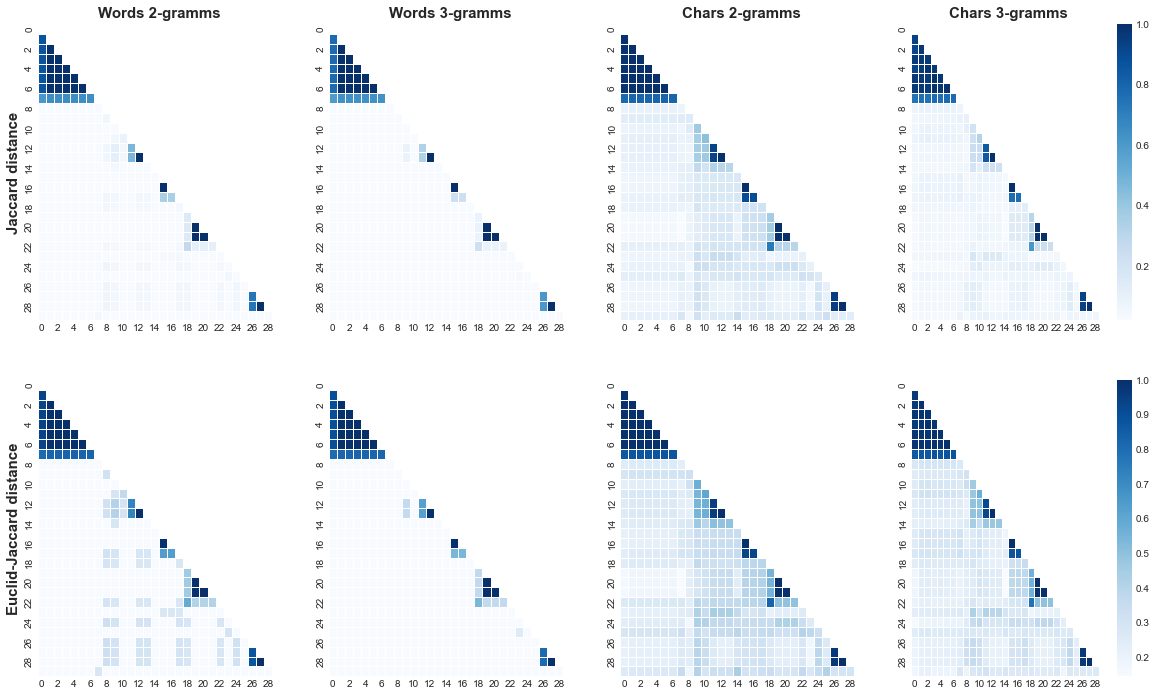

In [69]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4,figsize=(20,12))
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# ax1.set_title("Edit Distance",fontsize=45)
# sns.heatmap(ed_matrix,  linewidths=.5,cmap="Blues_r",fmt='.3g',mask=mask, ax=ax1)

ax1.set_title("Words 2-gramms",fontsize=15, fontweight='bold')
sns.heatmap(js2_matrix,  linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', cbar=False, ax=ax1)

ax2.set_title("Words 3-gramms",fontsize=15, fontweight='bold')
sns.heatmap(js3_matrix,  linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', cbar=False, ax=ax2)

ax3.set_title("Chars 2-gramms",fontsize=15, fontweight='bold')
sns.heatmap(jc2_matrix, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', cbar=False, ax=ax3)

ax4.set_title("Chars 3-gramms",fontsize=15, fontweight='bold')
sns.heatmap(jc3_matrix, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax4)

ax1.set_ylabel("Jaccard distance", fontsize=15 , fontweight='bold')

# ax5.set_title("Euclid-Jaccard words 2-gramms",fontsize=15)
sns.heatmap(ejs2_matrix, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', cbar=False, ax=ax5)
ax5.set_ylabel("Euclid-Jaccard distance", fontsize=15, fontweight='bold')


# ax6.set_title("Euclid-Jaccard words 3-gramms",fontsize=15)
sns.heatmap(ejs3_matrix, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', cbar=False, ax=ax6)

# ax7.set_title("Euclid-Jaccard chars 2-gramms",fontsize=15)
sns.heatmap(ejc2_matrix, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', cbar=False, ax=ax7)

# ax8.set_title("Euclid-Jaccard chars 3-gramms",fontsize=15)
sns.heatmap(ejc3_matrix, linewidths=.5,cmap="Blues",mask=mask,fmt='.3g', ax=ax8)

# fig.tight_layout()
fig.savefig("heatmaps.png") 

### Edit Distance Heatmap

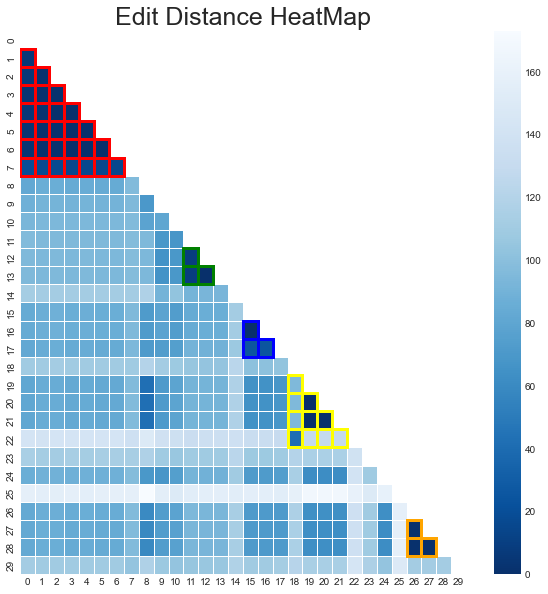

In [64]:
fif,ax = plt.subplots(1,figsize=(10,10))
colors = ['red','green','blue','yellow','orange']
c=0
for cl in clusters:
    for i  in range(0,len(cl)):
        for j in range(i+1,len(cl)):
            ax.add_patch(Rectangle(( cl[i],cl[j]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
    c+=1
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(ed_matrix, linewidth=0.5,cmap="Blues_r",mask=mask,fmt='.3g',ax=ax)
ax.set_title("Edit Distance HeatMap",fontsize=25)

# plt.legend(legendclusters,colors)
# print(legendclusters)
fif.savefig("edit-heatmap.png") 
plt.show()

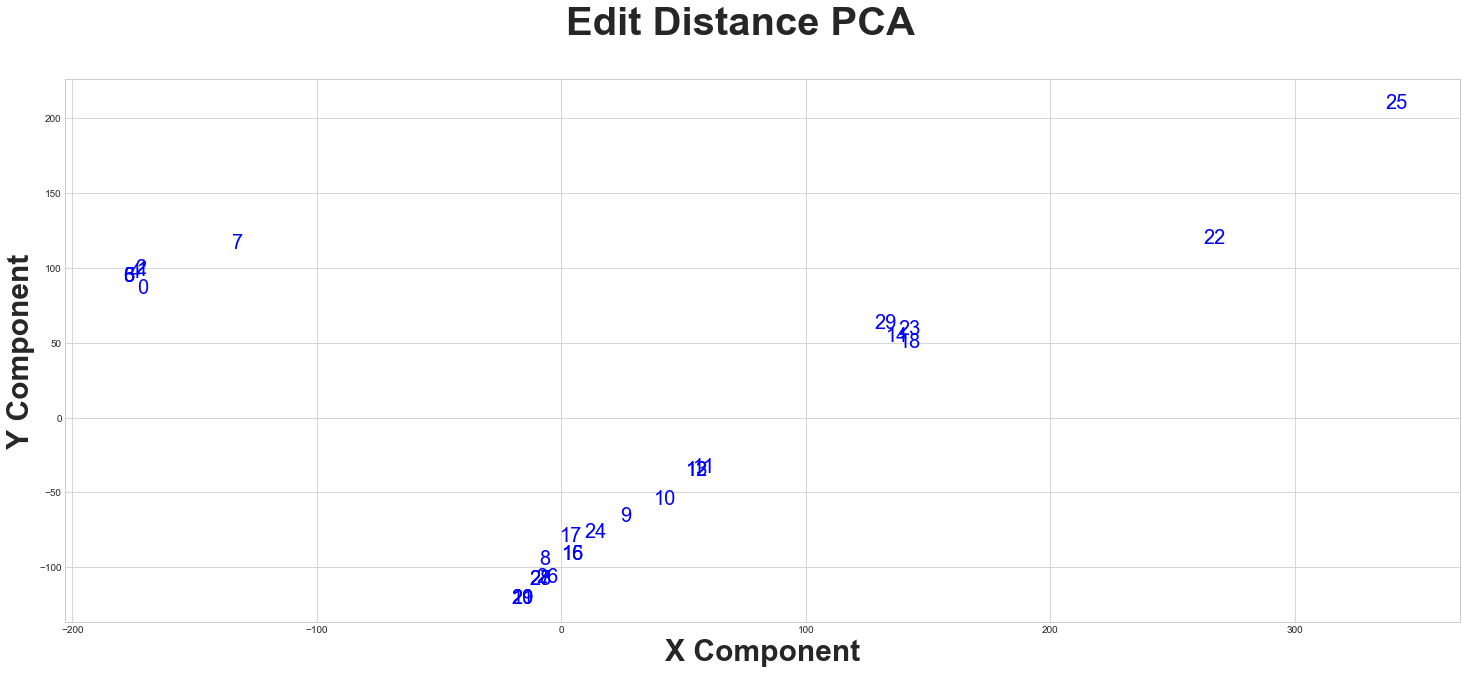

In [23]:
pcaComponents = PCA_SpaceVisualization(ed_matrix, 'Edit Distance PCA')

### Jaccard distance - using bgramms (2,3) Heatmap

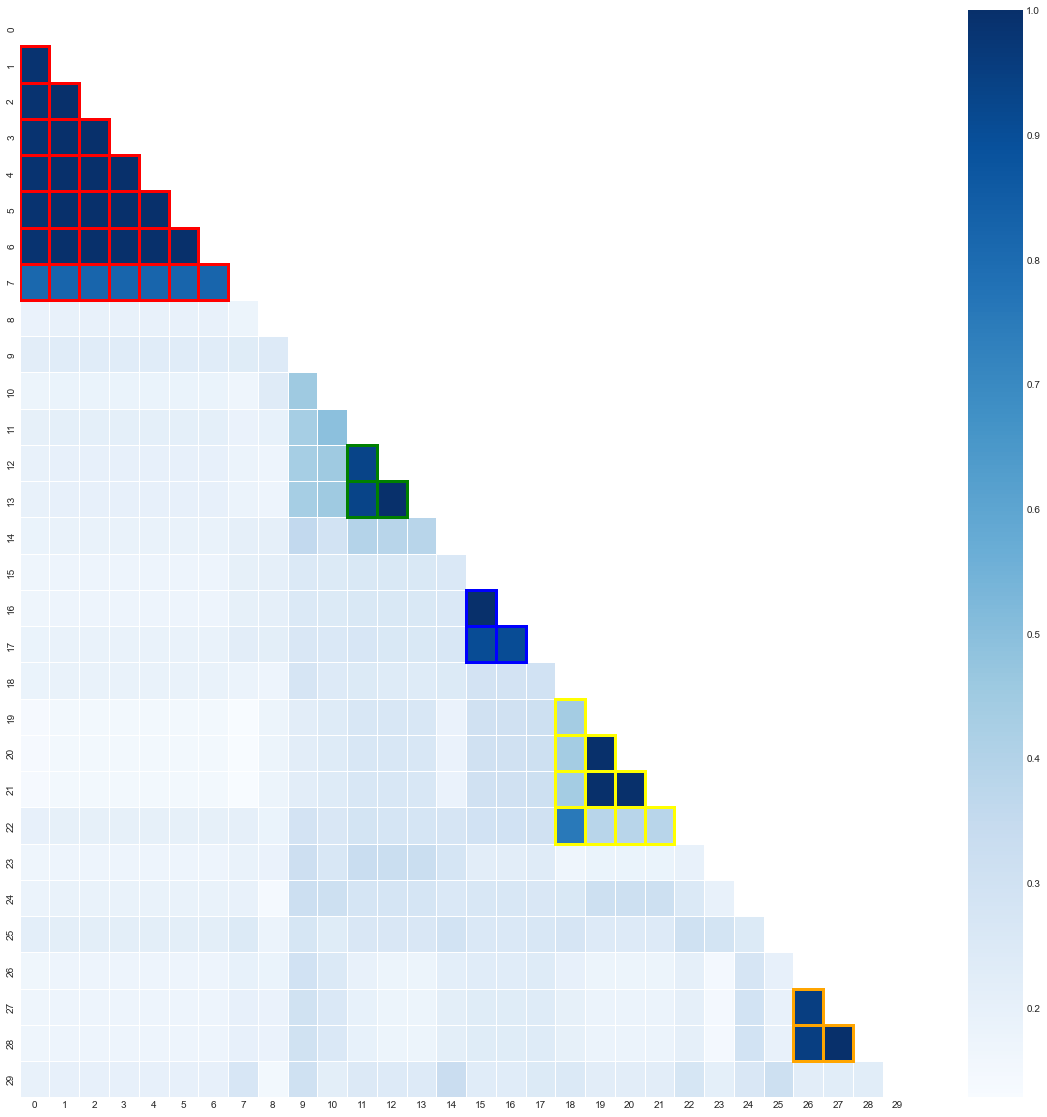

In [27]:
fif,ax = plt.subplots(1,figsize=(20,20))
colors = ['red','green','blue','yellow','orange']
c=0
for cl in clusters:
    for i  in range(0,len(cl)):
        for j in range(i+1,len(cl)):
            ax.add_patch(Rectangle((cl[i],cl[j]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
    c+=1
corr = np.corrcoef(ed_matrix)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(jc2_matrix, linewidth=0.5,cmap="Blues",mask=mask,fmt='.2g',ax=ax)
plt.show()

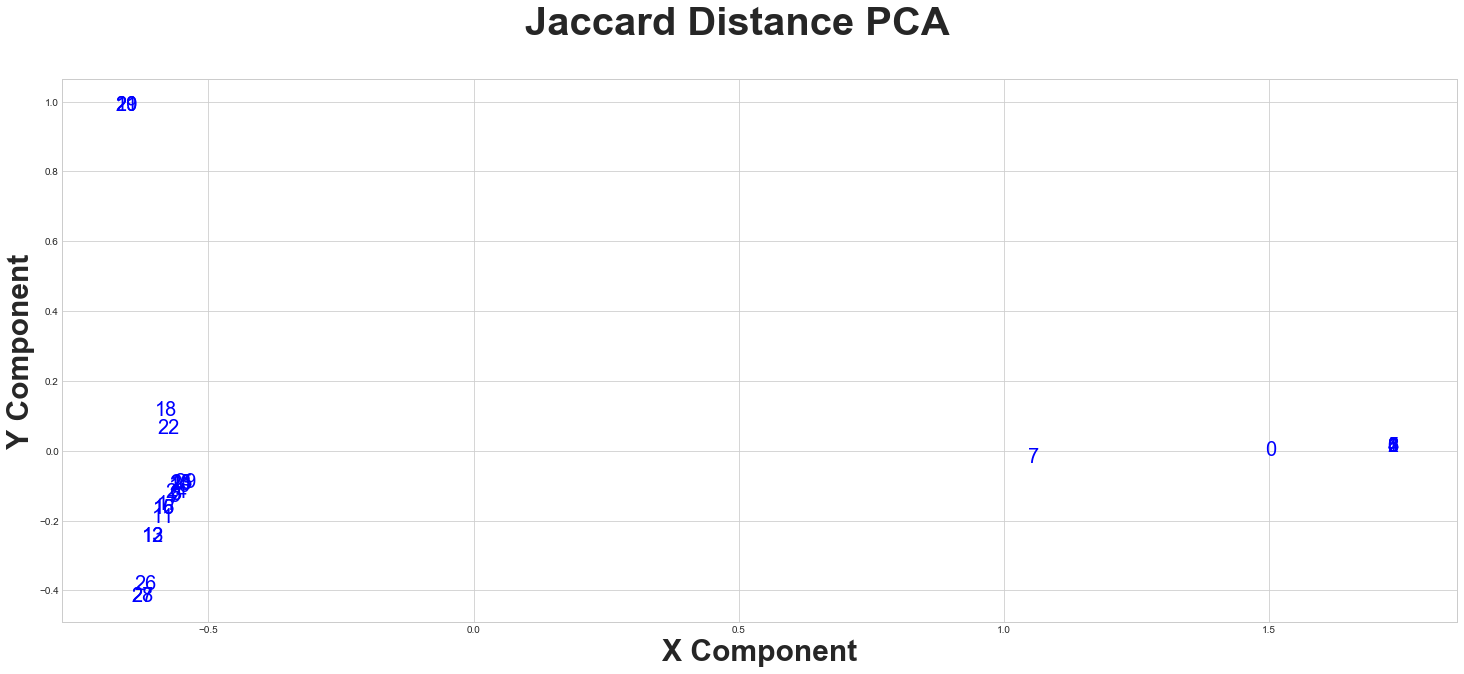

In [25]:
pcaComponents = PCA_SpaceVisualization(js2_matrix,  'Jaccard Distance PCA')

### Evaluation

In [26]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 3 13 16 21 28]
3  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
16  ->  brown  d. f.  moura  h. & watt  d. a. actress: an action semantics directed compiler generator  nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0205 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 3 2 5 4]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 4 5]
 [1 3 2 5 4]
 [2 5 4 3 1]
 [3 1 4 5 2]
 [5 1 3 4 2]
 [2 1 4 3 5]
 [2 1 4 3 5]
 [2 1 4 3 5]
 [2 1 4 5 3]
 [4 5 1 2 3]
 [4 5 1 2 3]
 [4 5 1 2 3]
 [4 5 2 1 3]
 [4 3 2 1 5]
 [4 3 2 1 5]
 [4 3 2 1 5]
 [5 4 2 1 3]
 [4 1 3 5 2]
 [5 4 3 1 2]
 [3 4 2 1 5]
 [3 5 2 4 1]
 [3 5 2 4 1]
 [3 5 2 4 1]
 [5 2 1 4 3]]

# Finished in 0.0259 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0 0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 19, 20, 21, 25]
[1 2]  ->  [8, 15, 16, 17, 18, 26, 27, 28]
[2 1]  ->  [9, 10, 22, 23, 24, 29]

- WTA number of buckets:  3

- WTA RankedVectors after permutation:
[[4 1 3]
 [5 1 3]
 [5 1 3]
 [5 1 3]
 [5 1 3]
 [5 1 3]
 [5 1 3]
 [4 1 3]
 [1 2 5]
 [2 3 1]
 [2 5 1]
 [5 2 1]
 [5 2 1]
 [5

[0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 19, 20, 21, 25]
0.7999999999999999
0.7999999999999999
0.7999999999999999
0.7999999999999999
0.7999999999999999
0.7999999999999999
0.9999999999999999
0.19999999999999998
0.19999999999999998
0.19999999999999998
0.39999999999999997
-0.19999999999999998
-0.19999999999999998
-0.19999999999999998
0.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.7999999999999999
0.39999999999999997
0.39999999999999997
0.39999999999999997
0.19999999999999998
0.0
0.0
0.0
0.19999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.7999999999999999
0.39999999999999997
0.39999999999999997
0.39999999999999997
0.19999999999999998
0.0
0.0
0.0
0.19999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.7999999999999999
0.39999999999999997
0.39999999999999997
0.39999999999999997
0.19999999999999998
0.0
0.0
0.0
0.19999999999999998
0.9999999999999999
0.9999999999999999
0.79

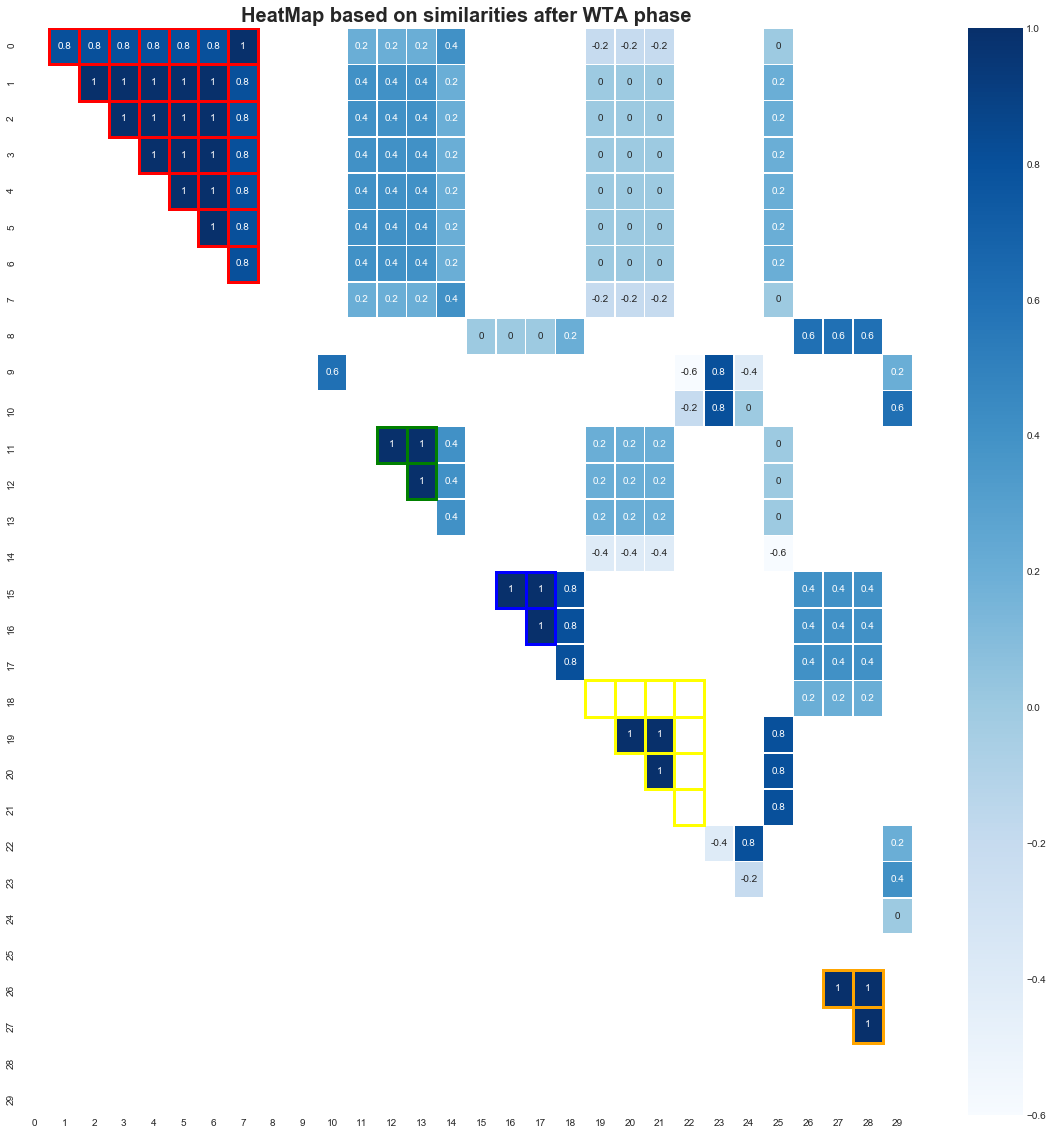

Wall time: 966 ms


In [44]:
%%time
model = RankedWTAHash(
    max_numberOf_clusters= 30,
    max_editDistance= 0.3,
    windowSize= 3,
    similarityThreshold= 0.799,
    metric='kendal',
    similarityVectors='initial',
    number_of_permutations = 2,
    distanceMetric= 'jaccard',
    distanceMetricEmbedding = 'jaccard',
    ngramms= 3,
    jaccard_withchars = True
)
model = model.fit(data)
evaluate_cora(model.mapping_matrix,true_matrix, False)
similarityProbsHeatMap(model.similarityProb_matrix,clusters,'HeatMap based on similarities after WTA phase')


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:




- Prototypes selected
[ 4 13 16 21 28]
4  ->  m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o.  inganas and m.r. andersson  nan j appl. phys. 
13  ->  benford  s.  bowers  j.  fahlen  l.e.  greenhalgh  c.  snowdon  d. user embodiment in collaborative virtual environments. nan
16  ->  brown  d. f.  moura  h. & watt  d. a. actress: an action semantics directed compiler generator  nan
21  ->  b. buth et. al.  provably correct compiler implementation  nan
28  ->  nan an investigation of niche and species formation in genetic function optimization. nan

- Final number of prototypes:  5

# Finished in 0.0199 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:



- Embeddings created
[[1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]
 [1 1 1 1 1]
 [2 1 2 2 2]
 [1 1 1 1 1]
 [2 1 2 2 2]
 [2 1 2 2 2]
 [2 1 2 2 2]
 [1 1 1 1 1]
 [2 2 1 2 2]
 [2 2 1 2 2]
 [2 2 1 2 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [2 2 2 1 2]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [2 2 2 2 1]
 [2 2 2 2 1]
 [2 2 2 2 1]
 [1 1 1 1 1]]

# Finished in 0.0260 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:
- WTA buckets: 
[0 0 1 0 0]  ->  [0, 1, 2, 3, 4, 5, 6, 7]
[0 0 0 0 0]  ->  [8, 10, 14, 23, 24, 25, 26, 27, 28, 29]
[1 0 0 0 0]  ->  [9, 11, 12, 13]
[0 0 0 1 1]  ->  [15, 16, 17]
[0 1 0 0 0]  ->  [18, 19, 20, 21, 22]

- WTA number of buckets:  5

- WTA RankedVectors after permutation:
[[2 2 2 2 1]
 [2 2 2 2 1]
 [2 2 2 2 1]
 [2 2 2 2 1]
 [2 2 2 2 1]
 

[0, 1, 2, 3, 4, 5, 6, 7]
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
0.45266500000000004
[8, 10, 14, 23, 24, 25, 26, 27, 28, 29]
0.321445
0.321445
0.321445
0.321445
0.321445
0.14944500000000002
0.14944500000000002
0.14944500000000002
0.321445
0.321445
0.321445
0.321445
0.321445
0.14944500000000002
0.14944500000000002
0.14944500000000002
0.321445
0.321445
0.321445
0.321445
0.14944500000000002
0.14944500000000002
0.14944500000000002
0.321445
0.321445
0.321445
0.14944500000000002
0.14944500000000002
0.

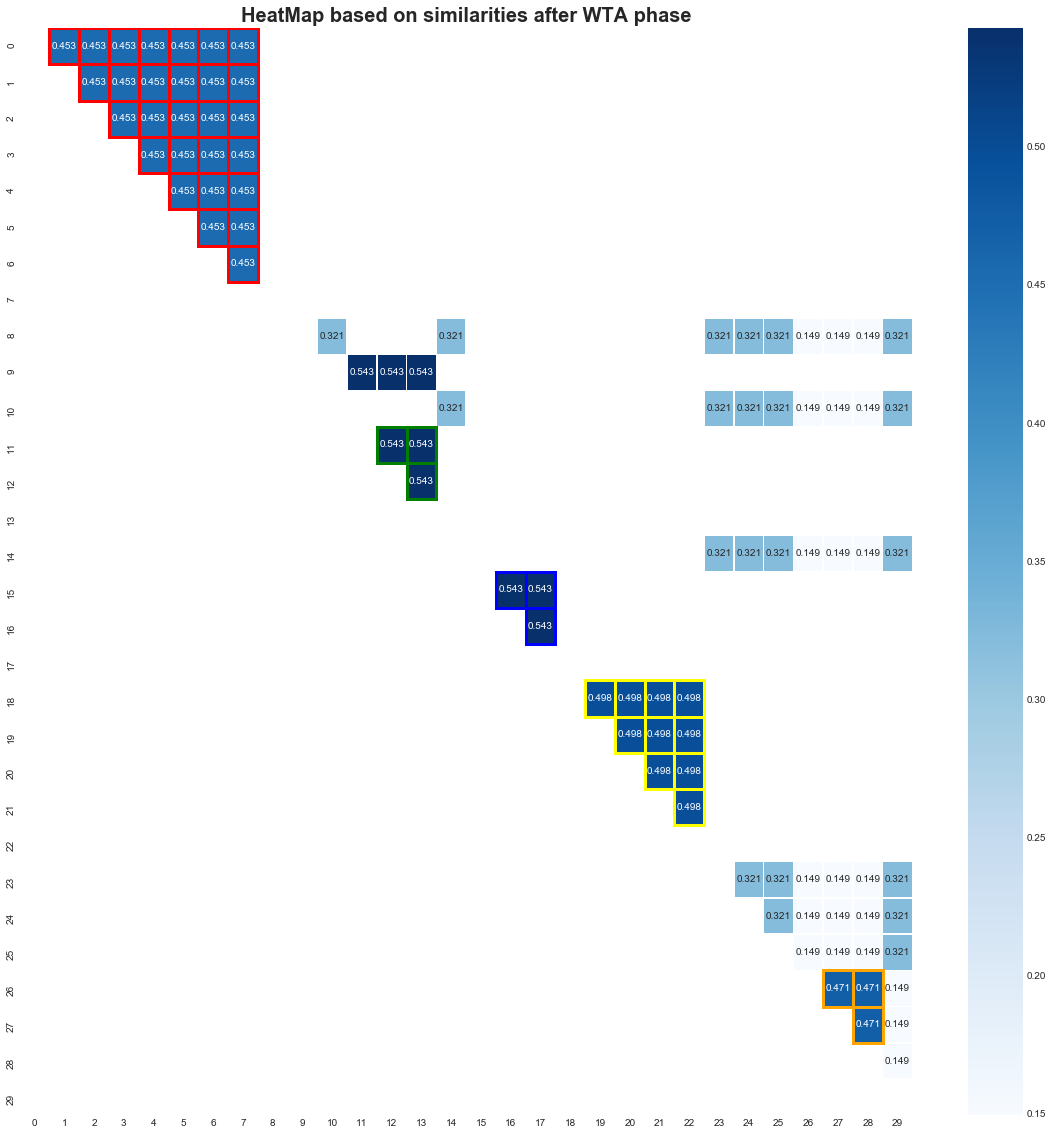

Wall time: 947 ms


In [39]:
%%time
model = RankedWTAHash(
    max_numberOf_clusters= 30,
    max_editDistance= 0.6,
    windowSize= 5,
    similarityThreshold= 0.799,
    metric='kendal',
    similarityVectors='ranked',
    number_of_permutations = 5,
    distanceMetric= 'jaccard',
    distanceMetricEmbedding = 'l_inf',
    ngramms= 3,
    jaccard_withchars = False
)
model = model.fit(data)
evaluate_cora(model.mapping_matrix,true_matrix, False)
print(np.array(model.similarityProb_matrix)
similarityProbsHeatMap(model.similarityProb_matrix,clusters,'HeatMap based on similarities after WTA phase')

## Performance details

### Embeddings

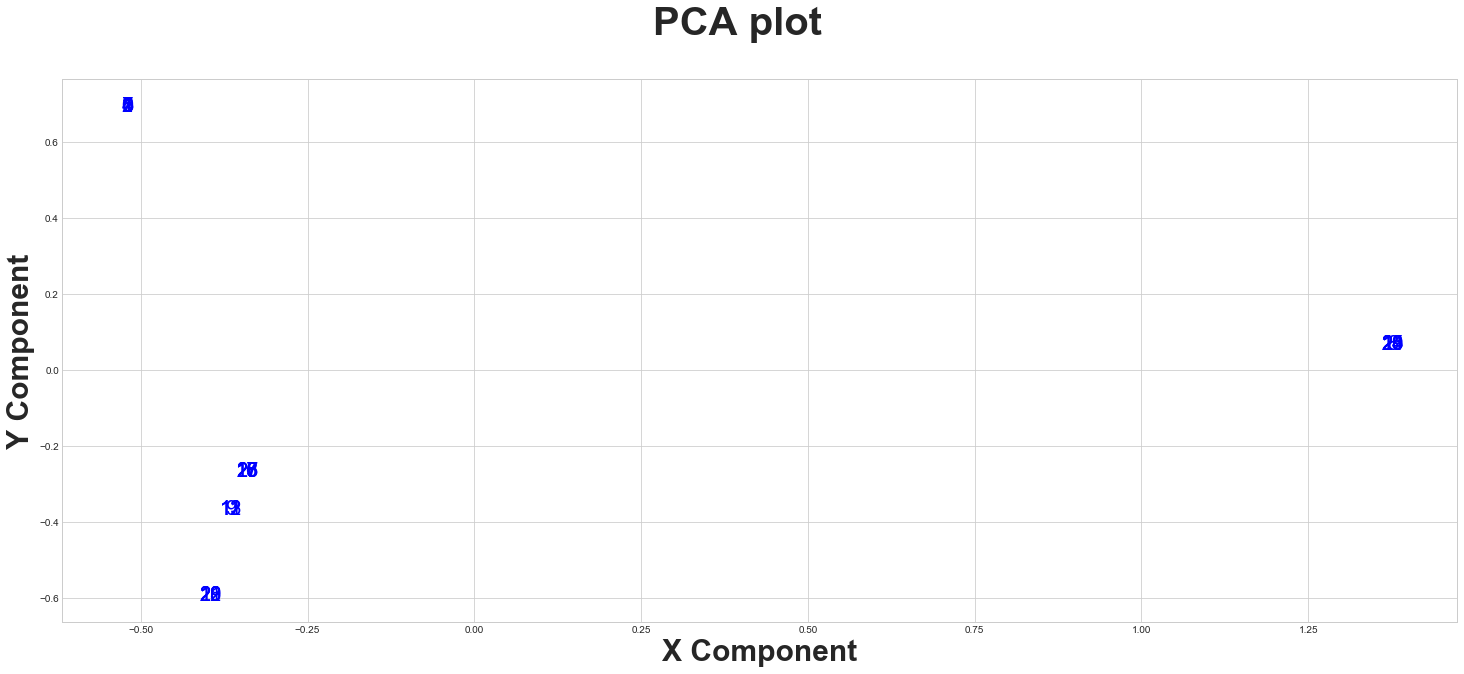

In [29]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

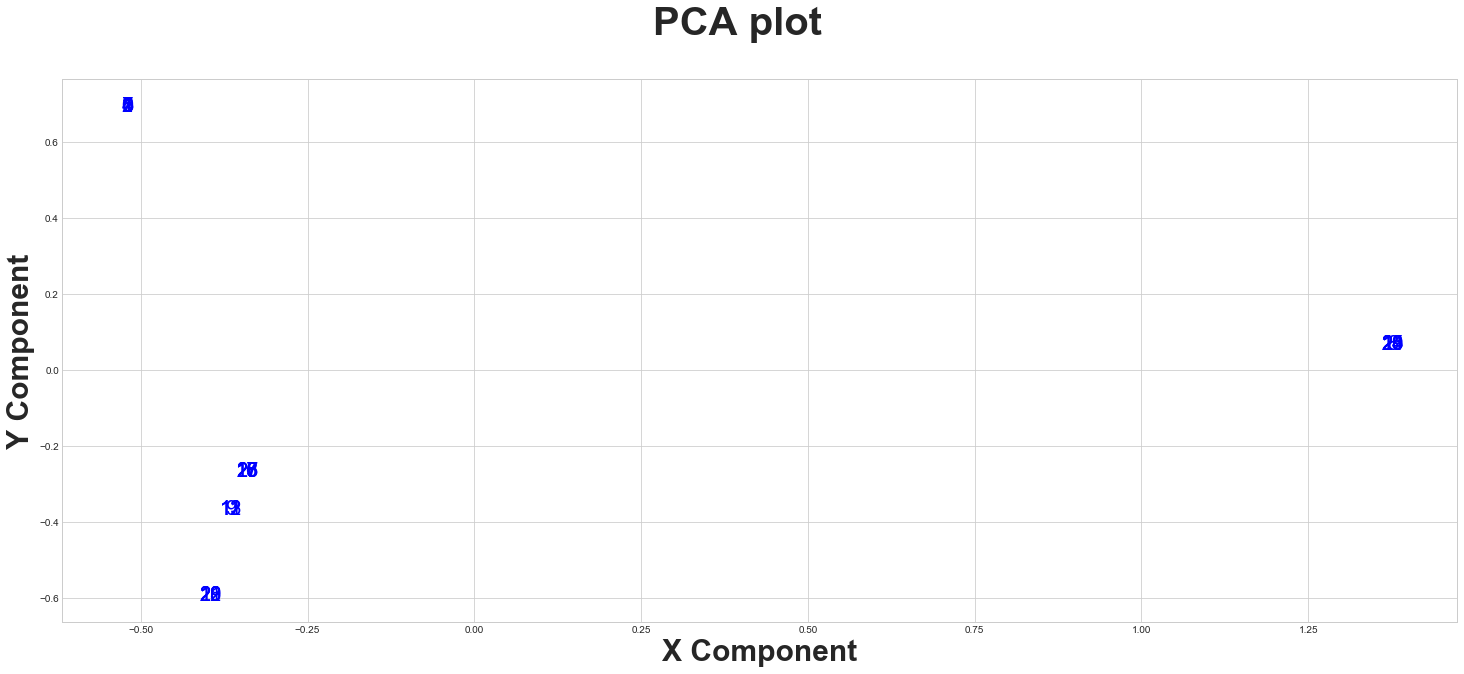

In [30]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

### Grid Search

In [31]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.6,0.7,0.8]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']
distanceMetric= ['edit']
distanceMetricEmbedding = ['edit','euclidean']
number_of_permutations = [1,3,5,7]


# results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

In [32]:
# results.sort_values(by=['Accuracy'],ascending=False)

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)